In [1]:
import os
if not os.path.exists("/scratch/sarthak"):
    os.makedirs("/scratch/sarthak")

os.environ["HF_HOME"] = "/scratch/sarthak/"

In [2]:
from datasets import load_dataset

In [3]:
import torch
import torch.nn.functional as F
# from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from typing import List, Tuple, Optional
import time
import numpy as np
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
# set random seed
torch.manual_seed(42)
import torch.nn as nn

In [52]:
class OnlineSpeculativeDecoder:
    def __init__(
        self,
        target_model_name = "t5-large",
        draft_model_name = "t5-small",
        gamma = 7,
        update_interval=4,
        temperature = 1.0,
    ):
        self.gamma = gamma
        self.update_interval = update_interval
        self.last_update_time = time.time()

        self.tokenizer = AutoTokenizer.from_pretrained(target_model_name)
        self.target_model = AutoModelForSeq2SeqLM.from_pretrained(target_model_name, device_map="auto")
        self.temperature = temperature
        self.run = 0


        config = LoraConfig(
            r = 16,
            lora_alpha = 16,
            target_modules = ["q", "v"],
            lora_dropout = 0.5,
            bias = "lora_only",
            modules_to_save=["decode_head"]
        )
        draft_model = AutoModelForSeq2SeqLM.from_pretrained(draft_model_name, device_map="auto")

        self.draft_model = get_peft_model(draft_model, config)


        self.target_model.eval()
        self.draft_model.eval()

        self.replay_buffer = []
        self.temp_buffer = [] 

        # Counter for iteration tracking
        self.iteration_count = 0

        self.padding_length = 128

        self.acceptance_rate = []
        self.losses = []

        self.time_taken = []

        self.optimizer = torch.optim.Adam(self.draft_model.parameters(), lr=1e-4)
        self.loss = nn.CrossEntropyLoss()

    def get_draft_logits(
            self,
            input_ids: torch.Tensor,
            attention_mask: torch.Tensor,
            decoder_input_ids: torch.Tensor,
            gamma: int
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Get draft logits for gamma tokens"""
        draft_tokens = []
        draft_probs = []
        current_decoder_ids = decoder_input_ids

        # Generate gamma tokens from the draft model
        for _ in range(gamma):
            with torch.no_grad():
                outputs = self.draft_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    decoder_input_ids=current_decoder_ids,
                    return_dict=True
                )
                logits = outputs.logits[:, -1, :]  # Get logits for last position
                probs = logits
                # probs = F.softmax(logits, dim=-1)

                # Sample token
                token_id = torch.argmax(probs, dim=-1)
                prob = probs.gather(-1, token_id.unsqueeze(-1)).squeeze(-1)

                draft_tokens.append(token_id.item())
                draft_probs.append(prob.item())

                # Update decoder inputs for next iteration
                current_decoder_ids = torch.cat(
                    [current_decoder_ids, token_id.view(1, 1)],
                    dim=1
                )

                if token_id.item() == self.tokenizer.eos_token_id:
                    break

        return draft_tokens, draft_probs, current_decoder_ids, outputs.logits

    def get_target_probs(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        decoder_input_ids: torch.Tensor,
        draft_tokens: torch.Tensor
    ) -> torch.Tensor:
        """Get target probabilities for the draft tokens in parallel."""
        with torch.no_grad():
            # Add draft tokens to decoder input
            full_decoder_ids = torch.cat([decoder_input_ids, draft_tokens.unsqueeze(0)], dim=1)

            decoder_mask = torch.ones(full_decoder_ids.shape[1])
            decoder_mask = decoder_mask.unsqueeze(0)

            outputs = self.target_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=full_decoder_ids,
                decoder_attention_mask=decoder_mask,
                return_dict=True
            )

            # Get probabilities for positions before each draft token
            logits = outputs.logits[:, -(len(draft_tokens) + 1):, :]
            logits = logits.squeeze(0)
            target_probs = F.softmax(logits, dim=-1)


            return target_probs.squeeze(0), logits, outputs.logits
        
    def get_logits(self, model, input_ids, attention_mask, decoder_input_ids):
        return model(
            input_ids=input_ids,
            decoder_input_ids=decoder_input_ids,
            attention_mask=attention_mask,
        ).logits

    def verify_tokens(
        self,
        target_probs: torch.Tensor,
        draft_tokens: torch.Tensor,
        draft_probs: torch.Tensor,
    ) -> int:
        """Determine number of accepted tokens"""
        # Get target probabilities for the draft tokens
        # get the probabilities of the tokens at the indices of the draft tokens
        target_probs_draft_tokens = torch.gather(target_probs, 1, draft_tokens.unsqueeze(0))
        # Calculate acceptance ratios
        acceptance_ratios = target_probs_draft_tokens / draft_probs.clamp(min=1e-10)

        # Sample uniform random numbers 
        random_nums = torch.rand_like(acceptance_ratios)
        acceptance_mask = random_nums <= acceptance_ratios

        num_accepted = (acceptance_mask.cumsum(dim=-1) == torch.arange(1, len(acceptance_ratios) + 1)).sum().item()

        return num_accepted

    def pad_to_2d(self, tensor_list, pad_token_id, max_len=None):
        if not isinstance(tensor_list[0], torch.Tensor):
            tensor_list = [torch.tensor(t).reshape(1, -1) for t in tensor_list]
        if max_len is None:
            max_len = max([t.shape[-1] for t in tensor_list])
        assert max_len > 0

        # Pad each tensor to the max length and stack them to form a 2D tensor
        result = torch.cat(
            [
                torch.nn.functional.pad(
                    tensor, (0, max_len - tensor.shape[-1]),
                    value=pad_token_id
                )
                for tensor in tensor_list
            ],
            dim=0
        )
        return result
        

    def soft_cross_entropy(self, predicts, targets, padding_mask=None):
        predict_log_prob = torch.nn.functional.log_softmax(predicts, dim=-1)
        targets_prob = torch.nn.functional.softmax(targets, dim=-1)
        entropy = -targets_prob * predict_log_prob
        expand_mask = padding_mask.unsqueeze(-1).expand_as(entropy)
        entropy.masked_fill_(expand_mask, 0)
        mean_entropy = entropy.sum() / (~padding_mask).sum()
        return mean_entropy

    def translate_dataset(
        self,
        sentences: List[str],
        max_length: int = 128
    ) -> List[str]:
        """Translate dataset using online speculative decoding."""

        self.iteration_count = 0
        self.replay_buffer = []

        translated_data = []

        for i in tqdm(range(len(sentences))):

            start_time = time.time()

            source_text = sentences[i]
            accepted = 0
            total_windows = 0

            encoder_inputs = self.tokenizer(
                f"translate English to German: {source_text}",
                return_tensors="pt",
                padding=True
            )

            
            decoder_input_ids = torch.tensor([[self.tokenizer.pad_token_id]])

            output = self.target_model(
                input_ids=encoder_inputs.input_ids,
                attention_mask=encoder_inputs.attention_mask,
                decoder_input_ids=decoder_input_ids,
                return_dict=True
            )

            probs = output.logits[:, -1, :]
                        
            probs = F.softmax(probs / (self.temperature + 1e-13), dim=-1)
            token_id = torch.multinomial(probs, num_samples=1)

            decoder_input_ids = torch.tensor([[self.tokenizer.pad_token_id, token_id.item()]])
            self.temp_buffer = []

            while decoder_input_ids.shape[1] < max_length:

                # Check for end of sequence
                if decoder_input_ids[0][-1].item() == self.tokenizer.eos_token_id:
                    break

                total_windows += 1

                # Get draft tokens autoregressively
                # print("Encoder Inputs", encoder_inputs.input_ids.shape)
                draft_tokens, draft_probs, proposed_decoder_ids, draft_logits = self.get_draft_logits(
                    encoder_inputs.input_ids,
                    encoder_inputs.attention_mask,
                    decoder_input_ids,
                    self.gamma
                )

                draft_tokens = torch.tensor(draft_tokens)
                draft_probs = torch.tensor(draft_probs)

                draft_probs = F.softmax(draft_probs / (self.temperature + 1e-13), dim=-1)

                if len(draft_tokens) == 0:
                    break

                # Get target probabilities in parallel
                target_probs, target_logits, raw_target_logits = self.get_target_probs(
                    encoder_inputs.input_ids,
                    encoder_inputs.attention_mask,
                    decoder_input_ids,
                    draft_tokens
                )

                # print("Iteration")

                # Verify tokens
                n_accepted = self.verify_tokens(target_probs, draft_tokens, draft_probs)

                if n_accepted > 0:
                    decoder_input_ids = torch.cat([
                        decoder_input_ids,
                        draft_tokens[:n_accepted].unsqueeze(0)
                    ], dim=1)

                n_rejected = len(draft_tokens) - n_accepted 
                accepted += n_accepted

                # print("Rejected", n_rejected)

                with torch.no_grad():
                    if n_rejected > 0:
                        probs = target_logits[-n_rejected, :]
                    else:
                        probs = target_logits[-1, :]
                    probs = F.softmax(probs / (self.temperature + 1e-13), dim=-1)
                    token_id = torch.multinomial(probs, num_samples=1).unsqueeze(0)
                    decoder_input_ids = torch.cat([decoder_input_ids, token_id], dim=1)
                # rejected_tokens = draft_tokens[n_accepted]
                if n_accepted < len(draft_tokens):

                    self.temp_buffer.append((encoder_inputs, decoder_input_ids, raw_target_logits, n_accepted, len(draft_tokens)))
            
            end_time = time.time()
            self.time_taken.append(end_time - start_time)

            self.acceptance_rate.append(accepted / (total_windows * self.gamma))

            self.replay_buffer.extend(self.temp_buffer)
            self.iteration_count += 1

            # decode the decoder input ids
            translation = self.tokenizer.decode(
                decoder_input_ids[0],
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )

            if self.iteration_count % self.update_interval == 0:
                # self.update_draft_model()
                self.draft_model.train()
                
                # finetune over collected tokens and logits

                # x[0] is encoder input, x[1] is decoder input, x[2] is target logits, x[3] is n_accepted
                encoder_input_ids = self.pad_to_2d([x[0].input_ids for x in self.replay_buffer], 0)
                # shape is replay_buffer_size, max_length of the sentences

                # pad attention mask with 0s to get the same shape
                max_sentence_length = max([x[0].attention_mask[0].shape[0] for x in self.replay_buffer])
                padded_attention_mask = []
                for i in range(len(self.replay_buffer)):
                    temp = torch.zeros(max_sentence_length, dtype=torch.bool)
                    temp[:self.replay_buffer[i][0].attention_mask[0].shape[0]] = self.replay_buffer[i][0].attention_mask[0]
                    padded_attention_mask.append(temp)

                encoder_attention_mask = torch.stack(padded_attention_mask, dim=0)

                decoder_input_ids = self.pad_to_2d([x[1] for x in self.replay_buffer], 0, self.padding_length)


                target_logits = [x[2] for x in self.replay_buffer]
                for i in range(len(target_logits)):
                    temp = torch.zeros(1, 32128).repeat(self.padding_length - target_logits[i].shape[1], 1).unsqueeze(0)
                    target_logits[i] = torch.cat([target_logits[i], temp], dim=1)

                n_accepted_tokens = [x[3] for x in self.replay_buffer]
                all_draft_tokens = [x[4] for x in self.replay_buffer]

                # CUDA out of memory error
                draft_logits = self.get_logits(self.draft_model, encoder_input_ids, encoder_attention_mask, decoder_input_ids).float()
                # print("Draft: \n", draft_logits)

                # need to get loss only using the wrong tokens
                # TODO: check if we need to ignore the pad tokens in the mask
                mask = torch.ones_like(decoder_input_ids, dtype=torch.bool)
                # print(n_accepted_tokens)
                for i in range(len(n_accepted_tokens)):
                    mask[i, n_accepted_tokens[i]:all_draft_tokens[i]] = False
                
                # stack target logits
                # target_logits = torch.stack(target_logits, dim=0)
                # print(target_logits.shape)
                # target_logits = torch.argmax(target_logits, dim=-1)
                # print(target_logits.shape)

                # print(draft_logits.shape)
                # print(target_logits[0].shape)
                target_logits = torch.stack(target_logits, dim=0)
                target_logits = target_logits.squeeze(1)    
                # print("Target: \n", target_logits)

                loss = self.soft_cross_entropy(draft_logits, target_logits, mask)
                print(loss)
                self.losses.append(loss.item())
                # print(draft_logits.shape)
                # print(target_logits[0].shape)
                # loss = self.loss(draft_logits.view(-1, 32128), target_logits[0].view(-1, 32128))
                loss.backward()
                self.optimizer.step()

                self.optimizer.zero_grad()
                self.draft_model.eval()

                # print the number of accepted tokens
                self.run += 1
                print(f"Iteration {self.iteration_count}: Accepted rate: {self.acceptance_rate[-1]}")
                print(f"Run Number: {self.run}\n\n")
                

                self.draft_model.eval()
                self.replay_buffer = []
                self.iteration_count = 0

            translated_data.append(translation)
        return translated_data

## Dataset stuff

In [57]:
dataset = load_dataset('wmt16', 'de-en', split='validation')

In [58]:
# make a set of all the english sentences
english_sentences = [x['translation']['en'] for x in dataset]


In [67]:
text = english_sentences[4]

In [76]:
# english_sentences = english_sentences[:120]
# english_sentences = english_sentences + english_sentences
english_sentences = []
for _ in range(120):
    english_sentences.append(text)

In [77]:
# training
online_decoder = OnlineSpeculativeDecoder()
translation = online_decoder.translate_dataset(english_sentences)

  3%|▎         | 4/120 [00:07<03:37,  1.87s/it]

tensor(1.6127, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.5714285714285714
Run Number: 1




  6%|▌         | 7/120 [00:14<04:23,  2.33s/it]

tensor(2.1944, grad_fn=<DivBackward0>)


  7%|▋         | 8/120 [00:16<04:28,  2.40s/it]

Iteration 4: Accepted rate: 0.32653061224489793
Run Number: 2




 10%|█         | 12/120 [00:22<03:09,  1.76s/it]

tensor(5.0862, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6857142857142857
Run Number: 3




 12%|█▎        | 15/120 [00:29<03:56,  2.25s/it]

tensor(4.4100, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.8214285714285714
Run Number: 4




 17%|█▋        | 20/120 [00:37<02:49,  1.69s/it]

tensor(2.7881, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6571428571428571
Run Number: 5




 20%|██        | 24/120 [00:43<02:38,  1.65s/it]

tensor(3.1126, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.7428571428571429
Run Number: 6




 23%|██▎       | 28/120 [00:51<03:01,  1.97s/it]

tensor(0.9144, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6857142857142857
Run Number: 7




 27%|██▋       | 32/120 [00:57<02:31,  1.73s/it]

tensor(2.7499, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.46938775510204084
Run Number: 8




 30%|███       | 36/120 [01:03<02:10,  1.55s/it]

tensor(2.0812, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.8214285714285714
Run Number: 9




 32%|███▎      | 39/120 [01:08<02:17,  1.70s/it]

tensor(1.8219, grad_fn=<DivBackward0>)


 33%|███▎      | 40/120 [01:11<02:38,  1.98s/it]

Iteration 4: Accepted rate: 0.4489795918367347
Run Number: 10




 37%|███▋      | 44/120 [01:17<02:07,  1.68s/it]

tensor(1.2744, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6571428571428571
Run Number: 11




 40%|████      | 48/120 [01:22<01:36,  1.33s/it]

tensor(0.6904, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.8571428571428571
Run Number: 12




 43%|████▎     | 52/120 [01:28<01:42,  1.50s/it]

tensor(3.2888, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.5714285714285714
Run Number: 13




 46%|████▌     | 55/120 [01:35<02:07,  1.96s/it]

tensor(4.0931, grad_fn=<DivBackward0>)


 47%|████▋     | 56/120 [01:38<02:30,  2.35s/it]

Iteration 4: Accepted rate: 0.4126984126984127
Run Number: 14




 50%|█████     | 60/120 [01:46<02:00,  2.01s/it]

tensor(4.6312, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6
Run Number: 15




 52%|█████▎    | 63/120 [01:52<01:57,  2.06s/it]

tensor(2.2413, grad_fn=<DivBackward0>)


 53%|█████▎    | 64/120 [01:54<01:50,  1.97s/it]

Iteration 4: Accepted rate: 0.8571428571428571
Run Number: 16




 57%|█████▋    | 68/120 [01:59<01:18,  1.50s/it]

tensor(4.8495, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.8214285714285714
Run Number: 17




 60%|██████    | 72/120 [02:05<01:10,  1.47s/it]

tensor(1.1746, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6857142857142857
Run Number: 18




 63%|██████▎   | 76/120 [02:12<01:14,  1.69s/it]

tensor(3.7277, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.5
Run Number: 19




 67%|██████▋   | 80/120 [02:18<01:03,  1.60s/it]

tensor(2.1577, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.7428571428571429
Run Number: 20




 70%|███████   | 84/120 [02:24<00:57,  1.60s/it]

tensor(1.0137, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6285714285714286
Run Number: 21




 72%|███████▎  | 87/120 [02:29<00:47,  1.44s/it]

tensor(4.8971, grad_fn=<DivBackward0>)


 73%|███████▎  | 88/120 [02:34<01:19,  2.50s/it]

Iteration 4: Accepted rate: 0.45714285714285713
Run Number: 22




 76%|███████▌  | 91/120 [02:39<00:57,  1.98s/it]

tensor(4.4202, grad_fn=<DivBackward0>)


 77%|███████▋  | 92/120 [02:41<00:58,  2.08s/it]

Iteration 4: Accepted rate: 0.4523809523809524
Run Number: 23




 80%|████████  | 96/120 [02:49<00:48,  2.04s/it]

tensor(1.8373, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.7142857142857143
Run Number: 24




 83%|████████▎ | 100/120 [02:55<00:32,  1.62s/it]

tensor(2.7619, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6
Run Number: 25




 87%|████████▋ | 104/120 [03:02<00:29,  1.86s/it]

tensor(3.1651, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.42857142857142855
Run Number: 26




 90%|█████████ | 108/120 [03:08<00:19,  1.62s/it]

tensor(2.5699, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.6285714285714286
Run Number: 27




 93%|█████████▎| 112/120 [03:15<00:12,  1.57s/it]

tensor(0.8530, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.8571428571428571
Run Number: 28




 97%|█████████▋| 116/120 [03:21<00:07,  1.80s/it]

tensor(3.2683, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.5510204081632653
Run Number: 29




100%|██████████| 120/120 [03:27<00:00,  1.73s/it]

tensor(2.9941, grad_fn=<DivBackward0>)
Iteration 4: Accepted rate: 0.8214285714285714
Run Number: 30




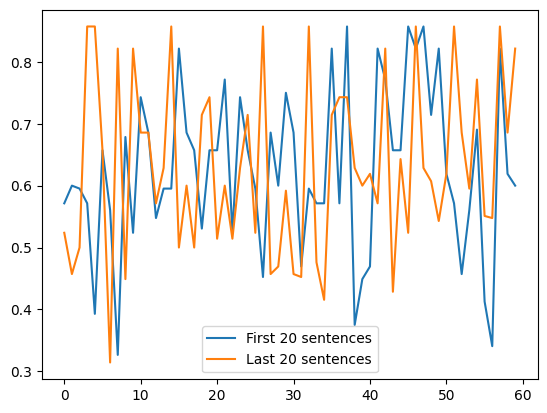

In [78]:
first = online_decoder.acceptance_rate[:60]
last = online_decoder.acceptance_rate[-60:]



import matplotlib.pyplot as plt

plt.plot(first)
plt.plot(last)
plt.legend(["First 20 sentences", "Last 20 sentences"])


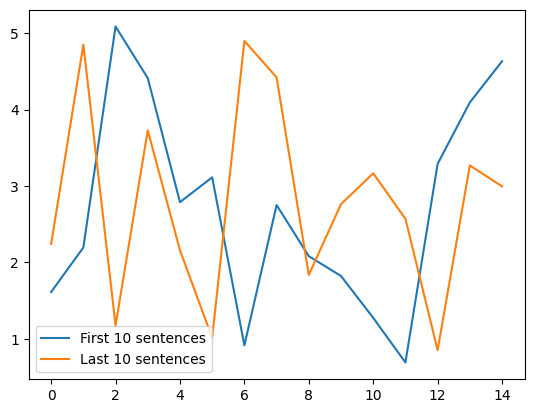

In [79]:
first = online_decoder.losses[:15]
last = online_decoder.losses[-15:]



import matplotlib.pyplot as plt

plt.plot(first)
plt.plot(last)
plt.legend(["First 10 sentences", "Last 10 sentences"])


In [80]:
import statistics

print(statistics.mean(online_decoder.acceptance_rate[:60]))
print(statistics.mean(online_decoder.acceptance_rate[-60:]))

print(statistics.mean(online_decoder.losses[:15]))
print(statistics.mean(online_decoder.losses[-15:]))

0.625656215477644
0.632272211915069
2.716616694132487
2.7954227328300476
